In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import itertools
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Input, GRU, Embedding, LSTM, Dropout

Using TensorFlow backend.


In [2]:
gear = pd.read_csv("C:/Users/pio-f/Desktop/gear2_dataset.csv", converters={"DATA0":lambda x: int(x, 16),"DATA1":lambda x: int(x, 16),"DATA2":lambda x: int(x, 16),"DATA3":lambda x: int(x, 16),"DATA4":lambda x: int(x, 16),"DATA5":lambda x: int(x, 16),"DATA6":lambda x: int(x, 16),"DATA7":lambda x: int(x, 16)})
gear.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478193e+09,0140,8,0,0,0,0,16,41,42,36,R
1,1.478193e+09,02c0,8,21,0,0,0,0,0,0,0,R
2,1.478193e+09,0350,8,5,32,68,104,119,0,0,126,R
3,1.478193e+09,0370,8,0,32,0,0,0,0,0,0,R
4,1.478193e+09,043f,8,16,64,96,255,120,196,8,0,R


In [3]:
gear['Timestamp'] = pd.to_datetime(gear['Timestamp'], origin=pd.Timestamp('2020-01-01'))
gear.sort_values(by = ["Timestamp","CAN ID"], inplace = True)
gear.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
8,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,6,11,112,R
32,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,12,111,R
44,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,13,114,R
68,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,14,246,R
81,2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,15,235,R


In [4]:
gear.set_index('Timestamp').head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
Timestamp,,,,,,,,,,,
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,6,11,112,R
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,12,111,R
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,7,13,114,R
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,14,246,R
2020-01-01 00:00:01.478193152,0002,8,0,0,0,0,0,8,15,235,R


In [5]:
gearT = gear[gear["Flag"] == "T"]
gearR = gear[gear["Flag"] == "R"]

In [6]:
gearT

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
2116,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2117,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2118,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2120,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2126,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
3498530,2020-01-01 00:00:01.478195200,043f,8,1,69,96,255,107,0,0,0,T
3498536,2020-01-01 00:00:01.478195200,043f,8,1,69,96,255,107,0,0,0,T
3498537,2020-01-01 00:00:01.478195200,043f,8,1,69,96,255,107,0,0,0,T
3498542,2020-01-01 00:00:01.478195200,043f,8,1,69,96,255,107,0,0,0,T


In [7]:
frames = [gearT,gearR]
dataset = pd.concat(frames)
dataset

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
2116,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2117,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2118,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2120,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
2126,2020-01-01 00:00:01.478193152,043f,8,1,69,96,255,107,0,0,0,T
...,...,...,...,...,...,...,...,...,...,...,...,...
4402166,2020-01-01 00:00:01.478201088,0690,8,0,0,0,0,160,34,0,0,R
4402349,2020-01-01 00:00:01.478201088,0690,8,0,0,0,0,160,34,0,0,R
4402532,2020-01-01 00:00:01.478201088,0690,8,0,0,0,0,160,34,0,0,R
4402715,2020-01-01 00:00:01.478201088,0690,8,0,0,0,0,160,34,0,0,R


In [8]:
dataset['Flag'].unique()

array(['T', 'R'], dtype=object)

In [9]:
X_input = dataset[['DATA0','DATA1','DATA2','DATA3','DATA4','DATA5','DATA6','DATA7']].values
y_target = dataset['Flag'].values

In [10]:
def temporalize(X,y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback):
        t = []
        for j in range(0, lookback):
            t.append(X[[i+j], :])
        output_X.append(t)
        output_y.append(y[i+lookback])
    return output_X,output_y

In [11]:
le = LabelEncoder()
y_target = le.fit_transform(y_target)

In [12]:
X_in, y_t = temporalize(X = X_input, y=y_target, lookback=10)

In [13]:
X_in = np.array(X_in)

In [14]:
X_in = X_in.reshape(X_in.shape[0],10,8)

In [15]:
X_in.shape

(4402967, 10, 8)

In [16]:
y_t = np.array(y_t)

In [17]:
y_t = to_categorical(y_t, 2)
y_t[0]
y_t.shape

(4402967, 2)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_in, y_t, test_size=0.3)

In [19]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(10,8)))
model.add(Dropout(0.2))
model.add(LSTM(40, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(40, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation="softmax" ))
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 20)            2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 40)            9760      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 60)            24240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 60)            0         
_______________________

In [20]:
model.compile(optimizer='rmsprop' , loss= 'mean_squared_error', metrics=['accuracy'])

In [21]:
history = History()

In [22]:
model.fit(X_train, y_train, epochs=5, batch_size = 1000, validation_split=0.1, callbacks=[history])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2773868 samples, validate on 308208 samples
Epoch 1/5





2773868/2773868 [==============================] - 280s 101us/step - loss: 5.9278e-04 - acc: 0.9996 - val_loss: 5.6690e-12 - val_acc: 1.0000
Epoch 2/5
2773868/2773868 [==============================] - 279s 100us/step - loss: 5.4092e-06 - acc: 1.0000 - val_loss: 7.2004e-09 - val_acc: 1.0000
Epoch 3/5
2773868/2773868 [==============================] - 276s 100us/step - loss: 5.3248e-05 - acc: 0.9999 - val_loss: 3.2772e-13 - val_acc: 1.0000
Epoch 4/5
2773868/2773868 [==============================] - 273s 99us/step - loss: 1.2311e-06 - acc: 1.0000 - val_loss: 2.6599e-13 - val_acc: 1.0000
Epoch 5/5
2773868/2773868 [==============================] - 269s 97us/step - loss: 7.2111e-07 - acc: 1.0000 - val_loss: 7.4496e-14 - val_acc: 1.0000


In [23]:
model.evaluate(X_test, y_test)

1320891/1320891 [==============================] - 144s 109us/step


[3.0280535754052897e-06, 0.9999969717410445]

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [25]:
y_pred = model.predict_classes(X_test, batch_size=1000, verbose = 0)

In [26]:
y_labels = np.argmax(y_test, axis=1)

In [27]:
cm = confusion_matrix(y_labels, y_pred)

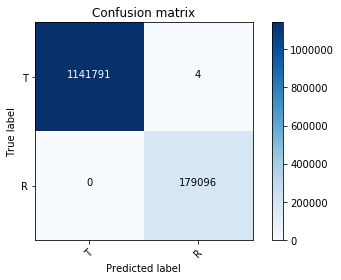

In [28]:
plot_confusion_matrix(cm, ['T','R'])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


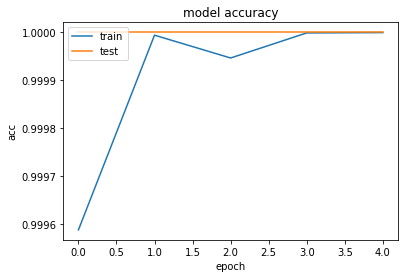

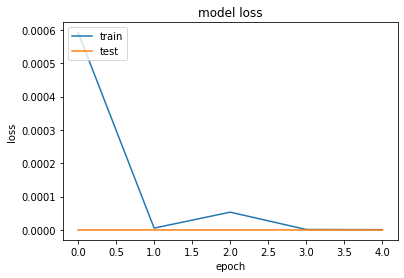

In [29]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()